In [1]:
import tensorflow.keras.backend as K
import multiprocessing

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import random
import logging

from gensim.models.word2vec import Word2Vec
import gensim

from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [2]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [3]:
#dataset_location = './datasets/sarcasm_v2.csv'
dataset_location = './datasets/text_and_annorations.csv'
model_location = './word2vec/'

corpus = []
labels = []

In [4]:
#Shuffle the dataset

ip=open(dataset_location,'r', encoding="utf8")
next(ip)
li = ip.readlines()
random.shuffle(li)

#dataset_location = './datasets/shuffled_sarcasm_v2.csv'
dataset_location = './datasets/shuffled_text_and_annotations.csv'

fid = open(dataset_location, "w", encoding="utf8")
fid.writelines(li)
fid.close()

In [5]:
# Parse tweets and sentiments       
with open(dataset_location, 'r', encoding="utf8") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    
    #skip the first line?
    #next(csvReader)
    
    for row in csvReader:
        #corpus.append(row[4])
        corpus.append(row[1])

        #Sarcasm label, (0 = not sarcasm, 1 = sarcasm)
        #pol = 1 if row[1] == 'sarc' else 0
        pol = 1 if row[5] == 'Yes' else 0
        labels.append(pol)
        
print('Corpus size: {}'.format(len(corpus)))

Corpus size: 994


In [6]:
# Tokenize and stem
tkr = RegexpTokenizer('[a-zA-Z0-9@]+')
#stemmer = LancasterStemmer()

tokenized_corpus = []

for i, tweet in enumerate(corpus):
    #tokens = [stemmer.stem(t) for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokens = [t for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokenized_corpus.append(tokens)

In [7]:
# Gensim Word2Vec model
vector_size = 300
window_size = 10

In [8]:
# Create Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#Google News model from https://github.com/3Top/word2vec-api
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)

2020-06-09 18:47:48,657 : INFO : loading projection weights from ./word2vec/GoogleNews-vectors-negative300.bin
2020-06-09 18:50:41,048 : INFO : loaded (3000000, 300) matrix from ./word2vec/GoogleNews-vectors-negative300.bin


In [9]:
#word2vec.most_similar(positive=['father', 'son'], topn=20)

In [10]:
# Copy word vectors and delete Word2Vec model and original corpus to save memory
X_vecs = word2vec.wv
#del word2vec
del corpus

/home/rbn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [11]:
# Train subset size (0 < size < len(tokenized_corpus))
train_size = math.floor(0.8 * len(tokenized_corpus))

# Test subset size (0 < size < len(tokenized_corpus) - train_size)
test_size = len(tokenized_corpus) - train_size

# Compute average and max tweet length
avg_length = 0.0
max_length = 0

for tweet in tokenized_corpus:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tokenized_corpus))))
print('Max tweet length: {}'.format(max_length))

Average tweet length: 23.5523138832998
Max tweet length: 201


In [12]:
# Tweet max length (number of tokens)
max_tweet_length = max_length

In [13]:
# Create train and test sets
# Generate random indexes
indexes = set(np.random.choice(len(tokenized_corpus), train_size + test_size, replace=False))

X_train = np.zeros((train_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((train_size, 2), dtype=np.int32)
X_test = np.zeros((test_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((test_size, 2), dtype=np.int32)

for i, index in enumerate(indexes):
    for t, token in enumerate(tokenized_corpus[index]):
        if t >= max_tweet_length:
            break
        
        if token not in X_vecs:
            continue
    
        if i < train_size:
            X_train[i, t, :] = X_vecs[token]
        else:
            X_test[i - train_size, t, :] = X_vecs[token]
            
    if i < train_size:
        Y_train[i, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]
    else:
        Y_test[i - train_size, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0] 

In [14]:
# Keras convolutional model
batch_size = 16
nb_epochs = 20

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same', input_shape=(max_tweet_length, vector_size)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 201, 16)           9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           1056      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 16)            1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [15]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [16]:
# Fit the model
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(X_test, Y_test))

Epoch 1/20
50/50 [==============================] - 7s 140ms/step - loss: 0.6335 - accuracy: 0.6465 - val_loss: 0.6048 - val_accuracy: 0.6533
Epoch 2/20
50/50 [==============================] - 2s 35ms/step - loss: 0.5958 - accuracy: 0.6679 - val_loss: 0.5796 - val_accuracy: 0.7487
Epoch 3/20
50/50 [==============================] - 2s 33ms/step - loss: 0.5480 - accuracy: 0.8000 - val_loss: 0.5226 - val_accuracy: 0.8040
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 0.4581 - accuracy: 0.8654 - val_loss: 0.4444 - val_accuracy: 0.8643
Epoch 5/20
50/50 [==============================] - 1s 29ms/step - loss: 0.3886 - accuracy: 0.9321 - val_loss: 0.4745 - val_accuracy: 0.8241
Epoch 6/20
50/50 [==============================] - 2s 33ms/step - loss: 0.3591 - accuracy: 0.9648 - val_loss: 0.4414 - val_accuracy: 0.8543
Epoch 7/20
50/50 [==============================] - 2s 30ms/step - loss: 0.3395 - accuracy: 0.9811 - val_loss: 0.4226 - val_accuracy: 0.8794
Epoch 8/20
5

In [17]:
loss, accuracy = model.evaluate(X_test, Y_test)

print("Loss: ", "%.3f" % loss)
print("Accuracy: ", "%.3f" % accuracy)

7/7 [==============================] - 0s 19ms/step - loss: 0.4091 - accuracy: 0.8995
Loss:  0.409
Accuracy:  0.899


# Graph

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

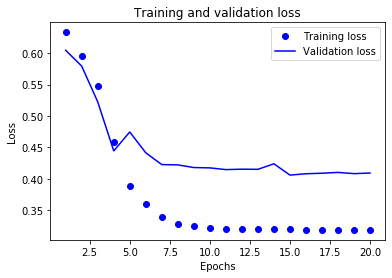

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

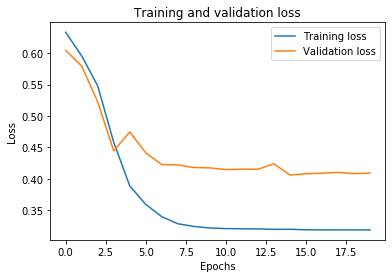

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.show()

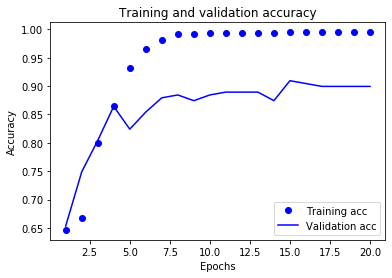

In [21]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

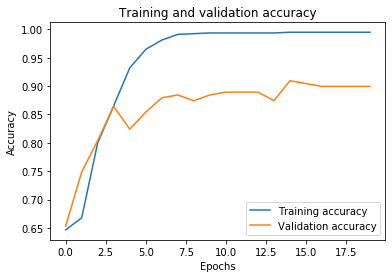

In [22]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predictions

In [23]:
def evaluate_phrase(tweet, model, word2vec, max_length, vector_size):
    #Tokenisation
    tkr = RegexpTokenizer('[a-zA-Z0-9@]+')
    tokens = [t for t in tkr.tokenize(tweet) if not t.startswith('@')]
    
    vectorized_tweet = np.zeros((1,max_tweet_length, vector_size), dtype=K.floatx())
    
    for i, token in enumerate(tokens):
        if token in word2vec.vocab:
            vectorized_tweet[0][i] = word2vec[token]
        
    prediction = model.predict(vectorized_tweet)
    print("NS: {:.2f}%".format(prediction[0][0]*100) + " S: {:.2f}%".format(prediction[0][1]*100))
    print("Non sarcasm" if prediction[0][0]>prediction[0][1] else "Sarcasm")

In [29]:
evaluate_phrase("Let's downvote someone just for misunderstanding!", model, word2vec, max_tweet_length, vector_size)

NS: 3.93% S: 96.07%
Sarcasm
